In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift, estimate_bandwidth
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.preprocessing import StandardScaler


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import cv2

# Directory containing your dataset of images
dataset_path = r"/content/drive/MyDrive/ML PROJECTS/Deforestation Detection/final dataset"

# Define the new dimensions
new_width = 500  # New width in pixels
new_height = 300  # New height in pixels

# Iterate through each image file in the dataset directory
for filename in os.listdir(dataset_path):
    if filename.endswith(".jpg") or filename.endswith(".jpeg") or filename.endswith(".png"):
        # Construct the full path to the image file
        image_path = os.path.join(dataset_path, filename)

        # Load the image
        image = cv2.imread(image_path)

        # Check if the image is loaded successfully
        if image is not None:
            # Resize the image
            resized_image = cv2.resize(image, (new_width, new_height))

            # Save the resized image (overwrite the original)
            cv2.imwrite(image_path, resized_image)

            print(f"Resized and saved: {image_path}")
        else:
            print(f"Failed to load: {image_path}")

print("Resize operation completed.")


Resized and saved: /content/drive/MyDrive/ML PROJECTS/Deforestation Detection/final dataset/rotated_image_LC08_L1TP_137044_20131224_20200912_02_T1.jpg
Resized and saved: /content/drive/MyDrive/ML PROJECTS/Deforestation Detection/final dataset/rotated_image_LC08_L1TP_137044_20141125_20200910_02_T1.jpg
Resized and saved: /content/drive/MyDrive/ML PROJECTS/Deforestation Detection/final dataset/rotated_image_LC08_L1TP_137044_20151112_20200908_02_T1.jpg
Resized and saved: /content/drive/MyDrive/ML PROJECTS/Deforestation Detection/final dataset/rotated_image_LC08_L1TP_137044_20160115_20200907_02_T1.jpg
Resized and saved: /content/drive/MyDrive/ML PROJECTS/Deforestation Detection/final dataset/rotated_image_LC08_L1TP_137044_20161216_20200905_02_T1.jpg
Resized and saved: /content/drive/MyDrive/ML PROJECTS/Deforestation Detection/final dataset/rotated_image_LC08_L1TP_137044_20171203_20200902_02_T1.jpg
Resized and saved: /content/drive/MyDrive/ML PROJECTS/Deforestation Detection/final dataset/ro

In [ ]:

def calculate_iou(mask1, mask2):
    intersection = np.logical_and(mask1, mask2)
    union = np.logical_or(mask1, mask2)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

def deforestation_segmentation(image_path, scale=1.0):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    pixels = image.reshape(-1, 3)

    num_clusters = 2

    kmeans = KMeans(n_clusters=num_clusters, n_init=10, random_state=42)
    kmeans.fit(pixels)

    cluster_labels = kmeans.labels_

    cluster_intensity = [np.mean(pixels[cluster_labels == i]) for i in range(num_clusters)]
    suitable_cluster_index = np.argmax(cluster_intensity)

    segmented_image = cluster_labels.reshape(image.shape[0], image.shape[1])

    deforestation_mask = segmented_image != suitable_cluster_index

    area_pixels = np.sum(deforestation_mask)
    area_meters_squared = area_pixels * scale * scale

    return image, deforestation_mask, area_meters_squared

def process_dataset_deforestation(dataset_path, scale=1.0):
    # Create output directory if it doesn't exist
    output_dir = os.path.join(dataset_path, "deforestation_masks")
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Process each image in the dataset directory
    for filename in os.listdir(dataset_path):
        if filename.endswith(".jpeg") or filename.endswith(".jpg"):
            image_path = os.path.join(dataset_path, filename)
            original_img, deforestation_mask, area = deforestation_segmentation(image_path, scale)

            # Save the deforestation mask
            mask_filename = os.path.splitext(filename)[0] + "_deforestation_mask.png"
            mask_filepath = os.path.join(output_dir, mask_filename)
            cv2.imwrite(mask_filepath, deforestation_mask.astype(np.uint8) * 255)

            # Print area information
            print(f"Area of deforested region in {filename}: {area} square meters")

# Define the dataset path
dataset_path = r"/content/drive/MyDrive/ML PROJECTS/Deforestation Detection/final dataset"
scale = 0.1  # Assuming each pixel represents 0.1 meter
process_dataset_deforestation(dataset_path, scale)


Area of deforested region in rotated_image_LC08_L1TP_137044_20131224_20200912_02_T1.jpg: 309.34000000000003 square meters
Area of deforested region in rotated_image_LC08_L1TP_137044_20141125_20200910_02_T1.jpg: 280.79 square meters
Area of deforested region in rotated_image_LC08_L1TP_137044_20151112_20200908_02_T1.jpg: 264.75 square meters
Area of deforested region in rotated_image_LC08_L1TP_137044_20160115_20200907_02_T1.jpg: 320.45000000000005 square meters
Area of deforested region in rotated_image_LC08_L1TP_137044_20161216_20200905_02_T1.jpg: 293.47 square meters
Area of deforested region in rotated_image_LC08_L1TP_137044_20171203_20200902_02_T1.jpg: 275.78000000000003 square meters
Area of deforested region in rotated_image_LC08_L1TP_137044_20181222_20200830_02_T1.jpg: 261.59000000000003 square meters
Area of deforested region in rotated_image_LC08_L1TP_137044_20191123_20200825_02_T1.jpg: 260.76000000000005 square meters
Area of deforested region in rotated_image_LC08_L1TP_137044_

In [ ]:
def kmeans_segmentation(image_path, scale=1.0):
    # Load the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB (sklearn uses RGB)

    # Flatten the image
    pixels = image.reshape(-1, 3)

    # Define the number of clusters (deforested and forested)
    num_clusters = 2

    # Apply K-means clustering
    kmeans = KMeans(n_clusters=num_clusters, n_init=10, random_state=42)
    kmeans.fit(pixels)

    # Get the cluster centers and labels
    cluster_labels = kmeans.labels_

    # Determine which cluster represents deforested areas
    # In this case, we assume that the cluster with lower green intensity represents deforested areas
    green_intensity = [np.mean(pixels[cluster_labels == i, 1]) for i in range(num_clusters)]
    deforested_cluster_index = np.argmin(green_intensity)

    # Reshape labels to match the original image shape
    segmented_image = cluster_labels.reshape(image.shape[0], image.shape[1])

    # Determine deforested areas
    deforested_area = segmented_image == deforested_cluster_index

    # Calculate the area of the segmented deforested region
    area_pixels = np.sum(deforested_area)
    area_meters_squared = area_pixels * scale * scale  # Convert pixels to square meters based on the scale

    return deforested_area

def calculate_deforestation_coverage(deforested_area):
    # Calculate the percentage of the image covered by deforested areas
    total_pixels = np.prod(deforested_area.shape)
    deforested_pixels = np.sum(deforested_area)
    coverage = (deforested_pixels / total_pixels) * 100
    return coverage

def evaluate_deforestation(dataset_path, scale=1.0):
    accuracies = []

    for filename in os.listdir(dataset_path):
        if filename.endswith(".jpg") or filename.endswith(".jpeg"):
            image_path = os.path.join(dataset_path, filename)
            deforested_area = kmeans_segmentation(image_path, scale)

            # Custom Accuracy Measure: Deforestation Coverage
            coverage = calculate_deforestation_coverage(deforested_area)
            accuracies.append((filename, coverage))

    return accuracies

# Example usage
dataset_path = r"/content/drive/MyDrive/ML PROJECTS/Deforestation Detection/final dataset"
scale = 0.1  # Assuming each pixel represents 0.1 meter
accuracies = evaluate_deforestation(dataset_path, scale)

# Print coverage for each image
for filename, coverage in accuracies:
    print(f"Image: {filename}, Deforestation Coverage: {coverage:.2f}%")


Image: rotated_image_LC08_L1TP_137044_20131224_20200912_02_T1.jpg, Deforestation Coverage: 20.62%
Image: rotated_image_LC08_L1TP_137044_20141125_20200910_02_T1.jpg, Deforestation Coverage: 18.72%
Image: rotated_image_LC08_L1TP_137044_20151112_20200908_02_T1.jpg, Deforestation Coverage: 17.65%
Image: rotated_image_LC08_L1TP_137044_20160115_20200907_02_T1.jpg, Deforestation Coverage: 21.36%
Image: rotated_image_LC08_L1TP_137044_20161216_20200905_02_T1.jpg, Deforestation Coverage: 19.56%
Image: rotated_image_LC08_L1TP_137044_20171203_20200902_02_T1.jpg, Deforestation Coverage: 18.39%
Image: rotated_image_LC08_L1TP_137044_20181222_20200830_02_T1.jpg, Deforestation Coverage: 17.44%
Image: rotated_image_LC08_L1TP_137044_20191123_20200825_02_T1.jpg, Deforestation Coverage: 17.38%
Image: rotated_image_LC08_L1TP_137044_20201227_20210310_02_T1.jpg, Deforestation Coverage: 17.80%
Image: rotated_image_LC09_L1TP_137044_20220208_20230428_02_T1.jpg, Deforestation Coverage: 20.32%
Image: rotated_image

Area of deforested region (Image 1): 309.34000000000003 square meters
Area of deforested region (Image 2): 293.47 square meters


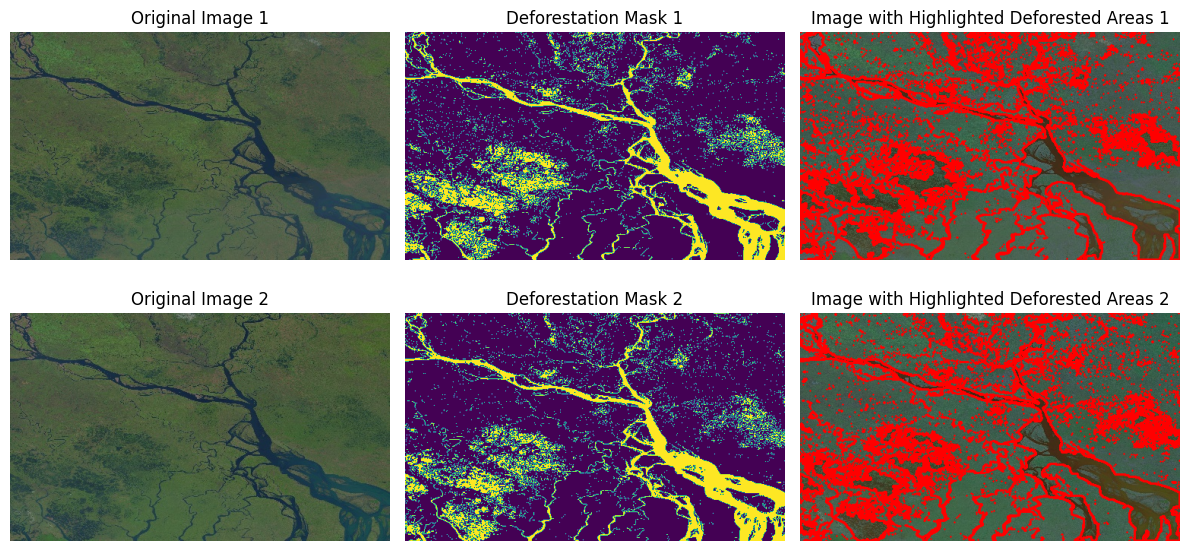

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

def kmeans_segmentation_deforestation(image_path, scale=1.0):
    try:
        # Load the image
        image = cv2.imread(image_path)

        # Check if the image is loaded successfully
        if image is None:
            raise ValueError("Unable to load the image. Please check the file path.")

        # Convert to RGB (sklearn uses RGB)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Flatten the image
        pixels = image.reshape(-1, 3)

        # Define the number of clusters (deforested and forested)
        num_clusters = 2

        # Apply K-means clustering
        kmeans = KMeans(n_clusters=num_clusters, n_init=10, random_state=42)  # Set random_state for consistent initialization
        kmeans.fit(pixels)

        # Get the cluster centers and labels
        cluster_labels = kmeans.labels_

        # Determine which cluster represents deforested areas
        # In this case, we assume that the cluster with lower green intensity represents deforested areas
        green_intensity = [np.mean(pixels[cluster_labels == i, 1]) for i in range(num_clusters)]
        deforested_cluster_index = np.argmin(green_intensity)

        # Reshape labels to match the original image shape
        segmented_image = cluster_labels.reshape(image.shape[0], image.shape[1])

        # Determine deforested areas
        deforestation_mask = (segmented_image == deforested_cluster_index)

        # Calculate the area of the segmented deforested region
        area_pixels = np.sum(deforestation_mask)
        area_meters_squared = area_pixels * scale * scale  # Convert pixels to square meters based on the scale

        # Find contours in the segmented image
        contours, _ = cv2.findContours((255 * deforestation_mask).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Draw contours on the original image to highlight deforested areas
        image_with_contours = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        cv2.drawContours(image_with_contours, contours, -1, (255, 0, 0), 2)  # Draw contours in red

        return image, deforestation_mask, image_with_contours, area_meters_squared
    except Exception as e:
        print(f"Error in processing image {image_path}: {e}")
        return None, None, None, None

# Example usage for the first image
image_path1 = r"/content/drive/MyDrive/ML PROJECTS/Deforestation Detection/final dataset/rotated_image_LC08_L1TP_137044_20131224_20200912_02_T1.jpg"
scale = 0.1  # Assuming each pixel represents 0.1 meter
original_img1, deforestation_mask1, image_with_contours1, area1 = kmeans_segmentation_deforestation(image_path1, scale)

# Check if image loading was successful before displaying
if original_img1 is not None:
    # Example usage for the second image
    image_path2 = r"/content/drive/MyDrive/ML PROJECTS/Deforestation Detection/final dataset/rotated_image_LC08_L1TP_137044_20161216_20200905_02_T1.jpg"
    original_img2, deforestation_mask2, image_with_contours2, area2 = kmeans_segmentation_deforestation(image_path2, scale)

    # Display the results for the first image
    plt.figure(figsize=(12, 6))

    plt.subplot(2, 3, 1)
    plt.imshow(original_img1)
    plt.title("Original Image 1")
    plt.axis('off')

    plt.subplot(2, 3, 2)
    plt.imshow(deforestation_mask1, cmap='viridis')
    plt.title("Deforestation Mask 1")
    plt.axis('off')

    plt.subplot(2, 3, 3)
    plt.imshow(image_with_contours1)
    plt.title("Image with Highlighted Deforested Areas 1")
    plt.axis('off')

    # Show the calculated area for the first image
    print(f"Area of deforested region (Image 1): {area1} square meters")

    # Display the results for the second image
    plt.subplot(2, 3, 4)
    plt.imshow(original_img2)
    plt.title("Original Image 2")
    plt.axis('off')

    plt.subplot(2, 3, 5)
    plt.imshow(deforestation_mask2, cmap='viridis')
    plt.title("Deforestation Mask 2")
    plt.axis('off')

    plt.subplot(2, 3, 6)
    plt.imshow(image_with_contours2)
    plt.title("Image with Highlighted Deforested Areas 2")
    plt.axis('off')

    # Show the calculated area for the second image
    print(f"Area of deforested region (Image 2): {area2} square meters")

    plt.tight_layout()
    plt.show()
else:
    print("Image loading failed.")


Area of deforested region (Image 1): 234.66 square meters


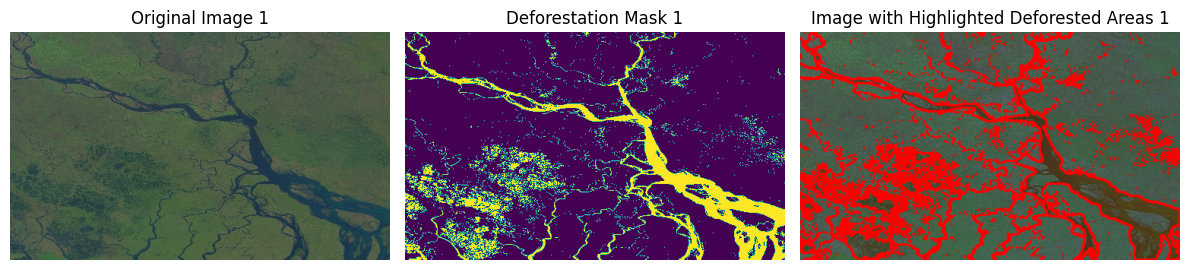

Area of deforested region (Image 2): 258.25 square meters


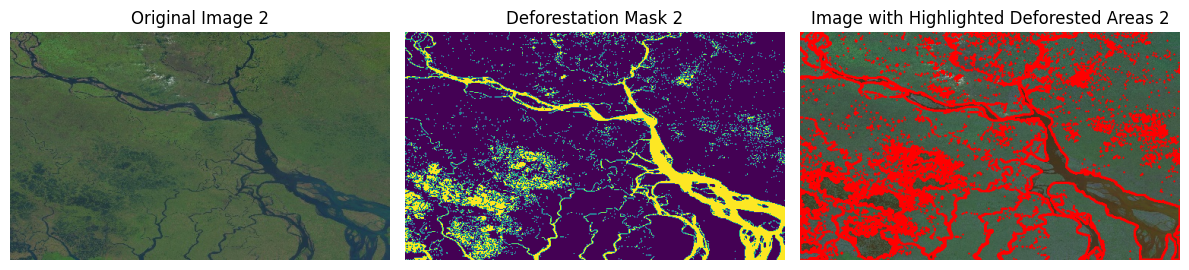

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import MeanShift, estimate_bandwidth
import cv2

def mean_shift_segmentation_deforestation(image_path, scale=1.0):
    # Load the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB

    # Flatten the image
    pixels = image.reshape(-1, 3)

    # Estimate bandwidth
    bandwidth = estimate_bandwidth(pixels, quantile=0.2, n_samples=500)

    # Apply Mean Shift clustering
    ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
    ms.fit(pixels)

    # Get labels and cluster centers
    labels = ms.labels_
    cluster_centers = ms.cluster_centers_

    # Reshape labels to match the original image shape
    segmented_image = labels.reshape(image.shape[0], image.shape[1])

    # Determine which cluster represents deforested areas
    # In this case, we assume that the cluster with lower green intensity represents deforested areas
    green_intensity = [np.mean(pixels[labels == i, 1]) for i in range(len(cluster_centers))]
    deforested_cluster_index = np.argmin(green_intensity)

    # Determine deforested areas
    deforestation_mask = (segmented_image == deforested_cluster_index)

    # Calculate the area of the segmented deforested region
    area_pixels = np.sum(deforestation_mask)
    area_meters_squared = area_pixels * scale * scale  # Convert pixels to square meters based on the scale

    # Find contours in the deforestation mask
    contours, _ = cv2.findContours((255 * deforestation_mask).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Draw contours on the original image to highlight deforested areas
    image_with_contours = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    cv2.drawContours(image_with_contours, contours, -1, (255, 0, 0), 2)  # Draw contours in red

    return image, deforestation_mask, image_with_contours, area_meters_squared

def process_images_deforestation(image_paths, scale=1.0):
    for i, image_path in enumerate(image_paths):
        original_img, deforestation_mask, image_with_contours, area = mean_shift_segmentation_deforestation(image_path, scale)

        # Display the results
        plt.figure(figsize=(12, 6))

        plt.subplot(1, 3, 1)
        plt.imshow(original_img)
        plt.title(f"Original Image {i+1}")
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(deforestation_mask, cmap='viridis')
        plt.title(f"Deforestation Mask {i+1}")
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(image_with_contours)
        plt.title(f"Image with Highlighted Deforested Areas {i+1}")
        plt.axis('off')

        # Show the calculated area for the image
        print(f"Area of deforested region (Image {i+1}): {area} square meters")

        plt.tight_layout()
        plt.show()

# Example usage for two images
image_paths = [r"/content/drive/MyDrive/ML PROJECTS/Deforestation Detection/final dataset/rotated_image_LC09_L1TP_137044_20221225_20230317_02_T1.jpg",
               r"/content/drive/MyDrive/ML PROJECTS/Deforestation Detection/final dataset/rotated_image_LC09_L1TP_137044_20231228_20231228_02_T1.jpg"]
scale = 0.1  # Assuming each pixel represents 0.1 meter
process_images_deforestation(image_paths, scale)


Estimated Deforested Area: 1.8400000000000003 square meters


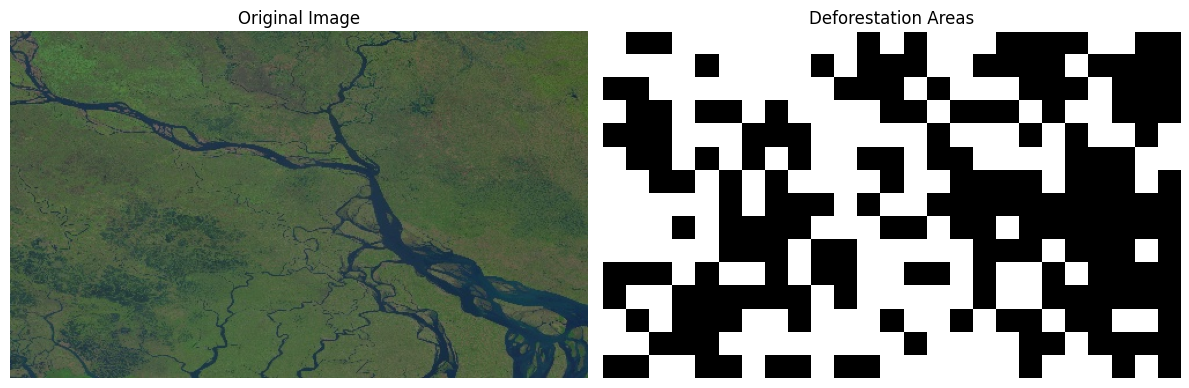

Estimated Deforested Area: 0.36000000000000004 square meters


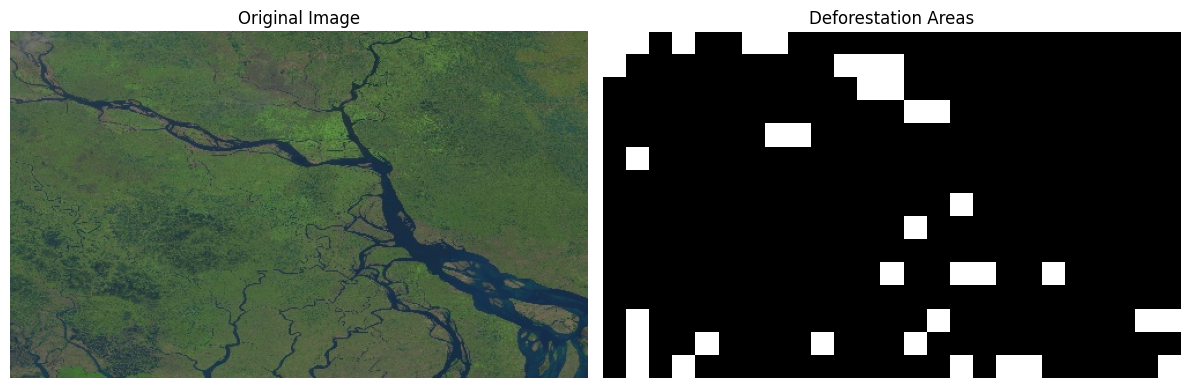

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.preprocessing import StandardScaler

def hierarchical_segmentation_deforestation(image_path, scale=1.0, downsample_factor=0.05):
    # Load the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB

    # Downsample the image
    small_image = cv2.resize(image, None, fx=downsample_factor, fy=downsample_factor)

    # Flatten the downsampled image
    pixels = small_image.reshape(-1, 3)

    # Standardize the pixel values
    scaler = StandardScaler()
    pixels_std = scaler.fit_transform(pixels)

    # Perform hierarchical clustering
    Z = linkage(pixels_std, method='ward')

    # Cut the dendrogram to get the labels
    max_d = 10  # Adjust this threshold as needed
    labels = fcluster(Z, max_d, criterion='distance')

    # Reshape labels to match the downsampled image shape
    segmented_image = labels.reshape(small_image.shape[0], small_image.shape[1])

    # Determine which cluster represents deforested areas
    # In this case, we assume that the cluster with higher mean intensity represents deforested areas
    unique_labels = np.unique(labels)
    cluster_intensity = [np.mean(pixels[labels == i]) for i in unique_labels]
    deforested_cluster_index = unique_labels[np.argmax(cluster_intensity)]

    # Determine deforested areas
    deforestation_mask = (segmented_image == deforested_cluster_index)

    # Calculate the area of the segmented deforested region
    area_pixels = np.sum(deforestation_mask)
    area_meters_squared = area_pixels * scale * scale  # Convert pixels to square meters based on the scale

    # Display the original image and deforestation mask
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title(f"Original Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(deforestation_mask, cmap='gray')
    plt.title(f"Deforestation Areas")
    plt.axis('off')

    # Show the calculated area for the image
    print(f"Estimated Deforested Area: {area_meters_squared} square meters")

    plt.tight_layout()
    plt.show()

# Example usage for two images
image_paths = [r"/content/drive/MyDrive/ML PROJECTS/Deforestation Detection/final dataset/rotated_image_LC08_L1TP_137044_20181222_20200830_02_T1.jpg",
               r"/content/drive/MyDrive/ML PROJECTS/Deforestation Detection/final dataset/rotated_image_LC09_L1TP_137044_20220208_20230428_02_T1.jpg"]

scale = 0.1  # Assuming each pixel represents 0.1 meter
downsample_factor = 0.05  # Adjust as needed

for image_path in image_paths:
    hierarchical_segmentation_deforestation(image_path, scale, downsample_factor)


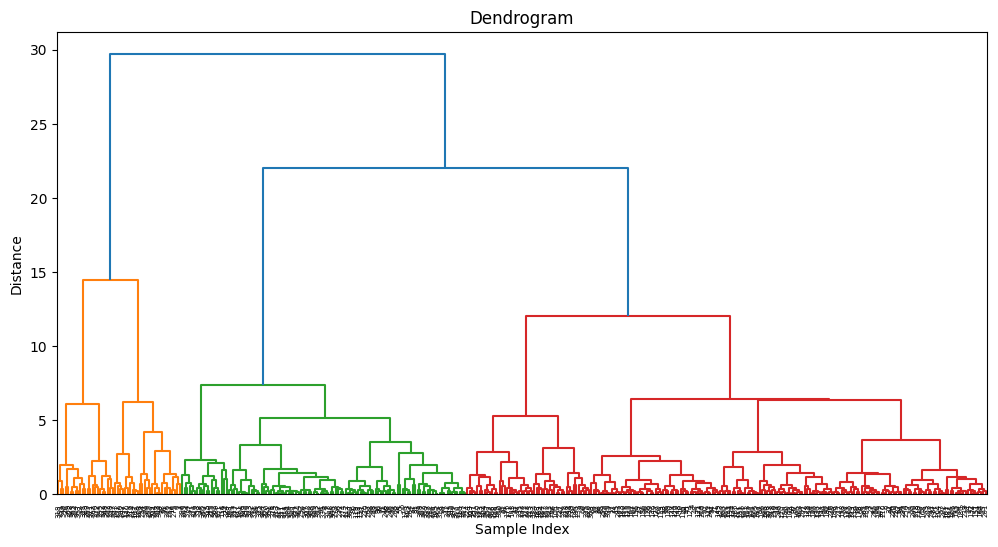

Processed: rotated_image_LC08_L1TP_137044_20131224_20200912_02_T1.jpg, Deforested Area: 55.63000000000001 square meters


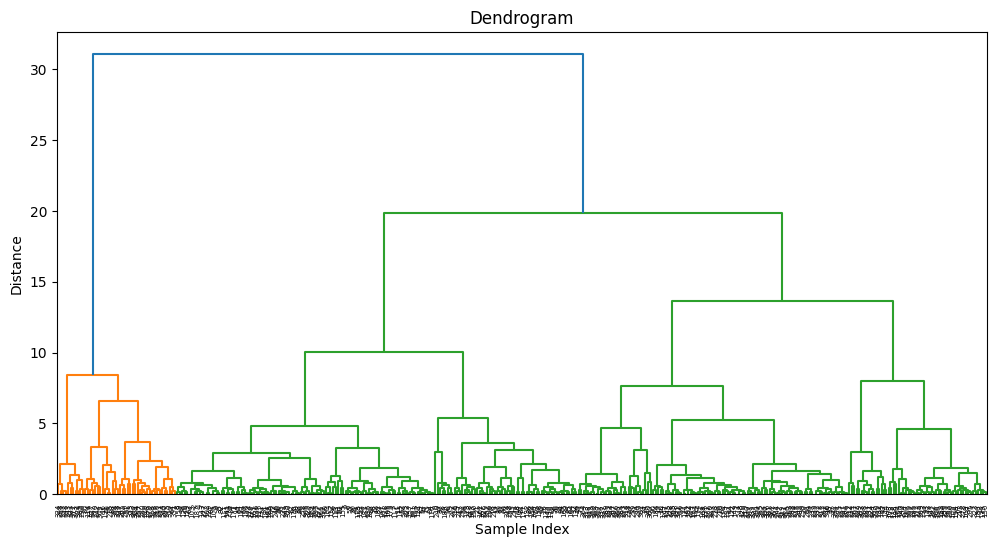

Processed: rotated_image_LC08_L1TP_137044_20141125_20200910_02_T1.jpg, Deforested Area: 93.84000000000002 square meters


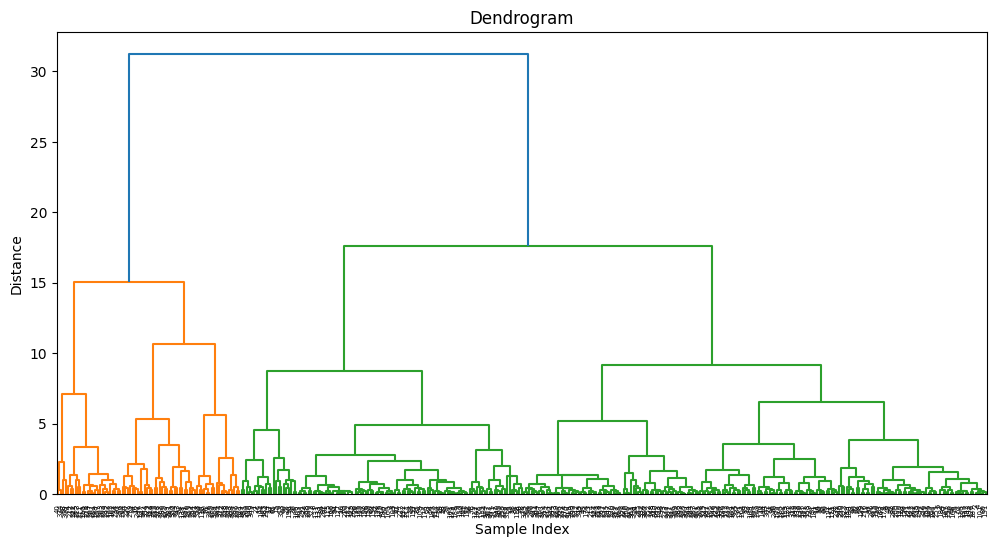

Processed: rotated_image_LC08_L1TP_137044_20151112_20200908_02_T1.jpg, Deforested Area: 14.14 square meters


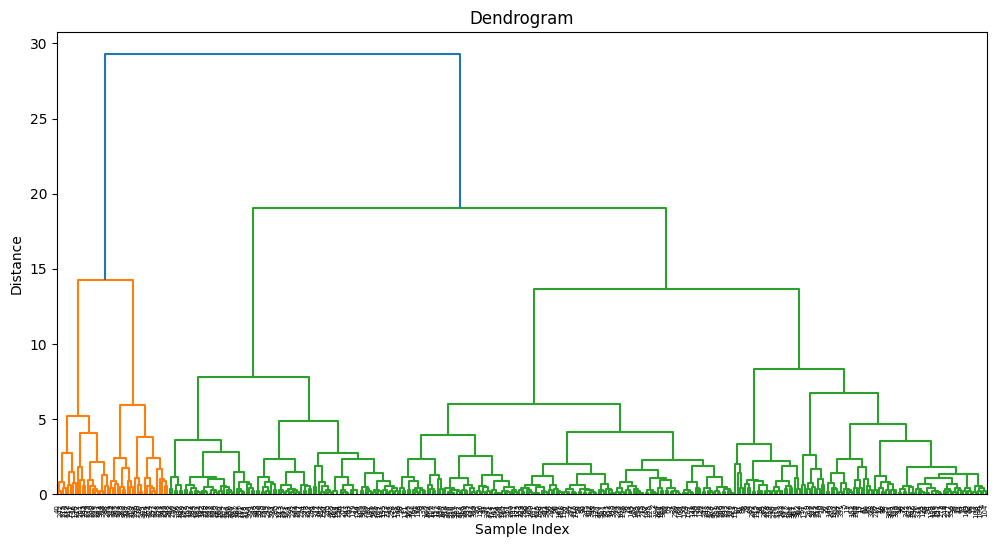

Processed: rotated_image_LC08_L1TP_137044_20160115_20200907_02_T1.jpg, Deforested Area: 19.360000000000003 square meters


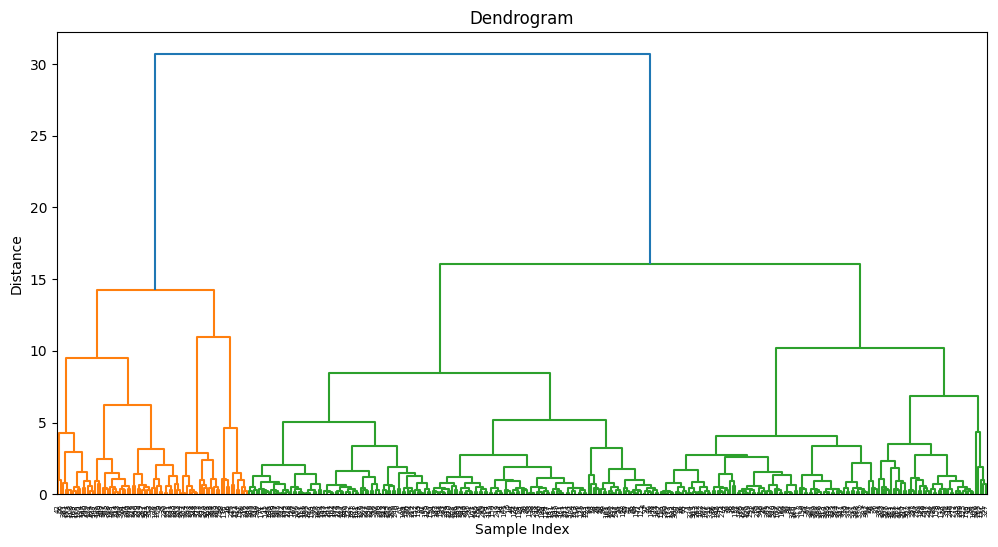

Processed: rotated_image_LC08_L1TP_137044_20161216_20200905_02_T1.jpg, Deforested Area: 58.120000000000005 square meters


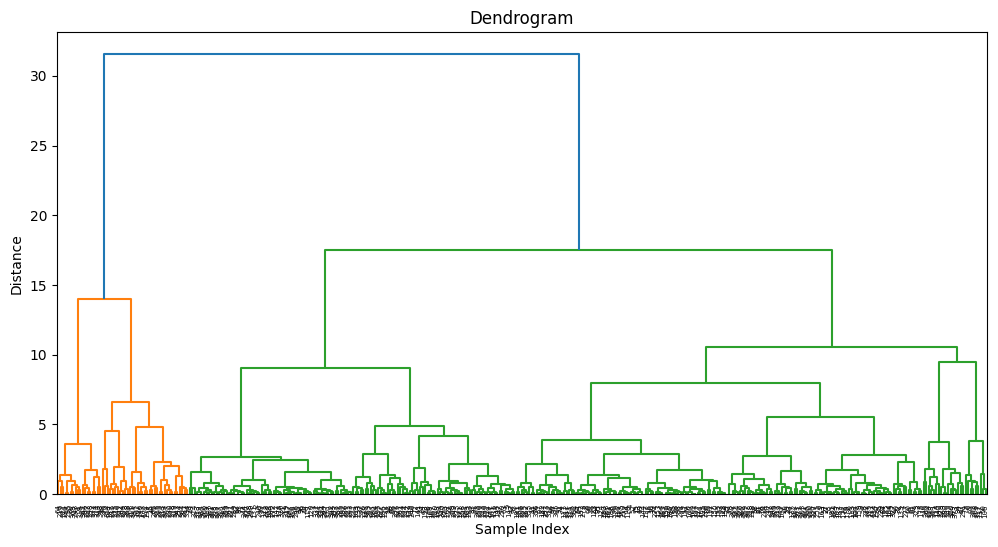

Processed: rotated_image_LC08_L1TP_137044_20171203_20200902_02_T1.jpg, Deforested Area: 25.040000000000003 square meters


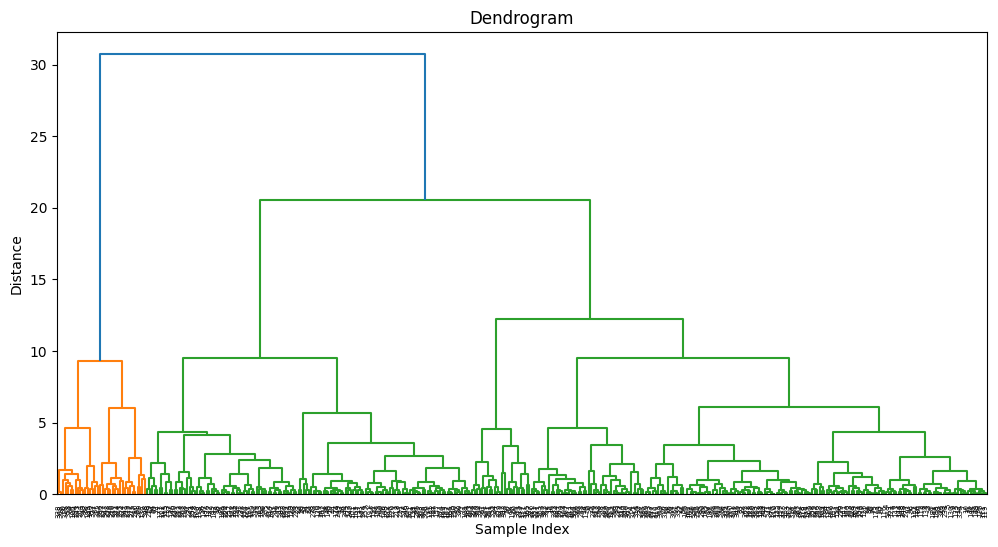

Processed: rotated_image_LC08_L1TP_137044_20181222_20200830_02_T1.jpg, Deforested Area: 65.64000000000001 square meters


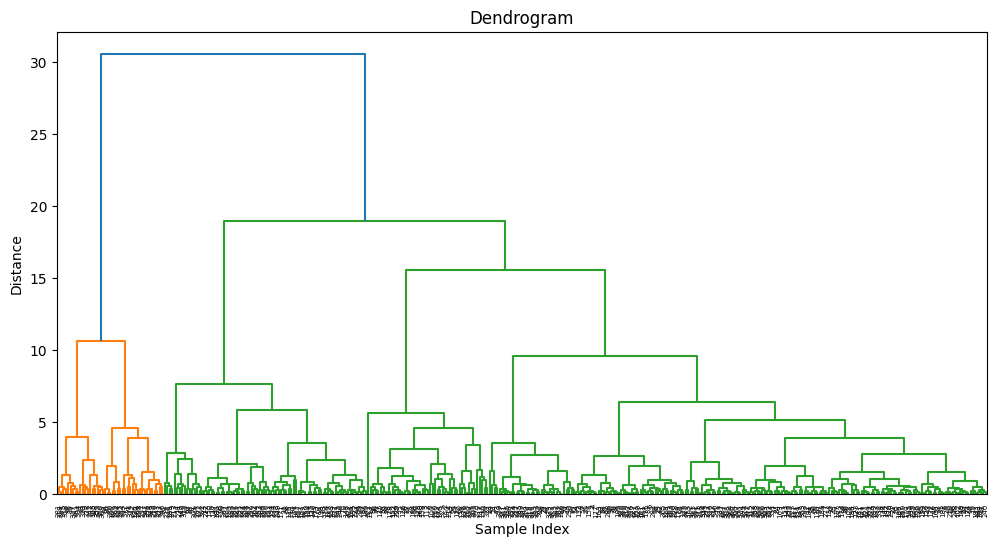

Processed: rotated_image_LC08_L1TP_137044_20191123_20200825_02_T1.jpg, Deforested Area: 22.760000000000005 square meters


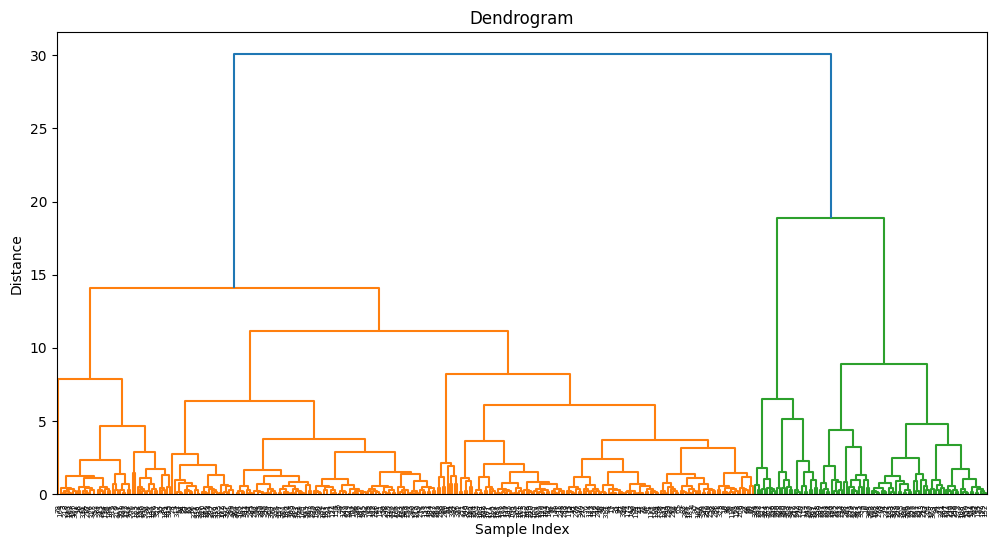

Processed: rotated_image_LC08_L1TP_137044_20201227_20210310_02_T1.jpg, Deforested Area: 106.17000000000002 square meters


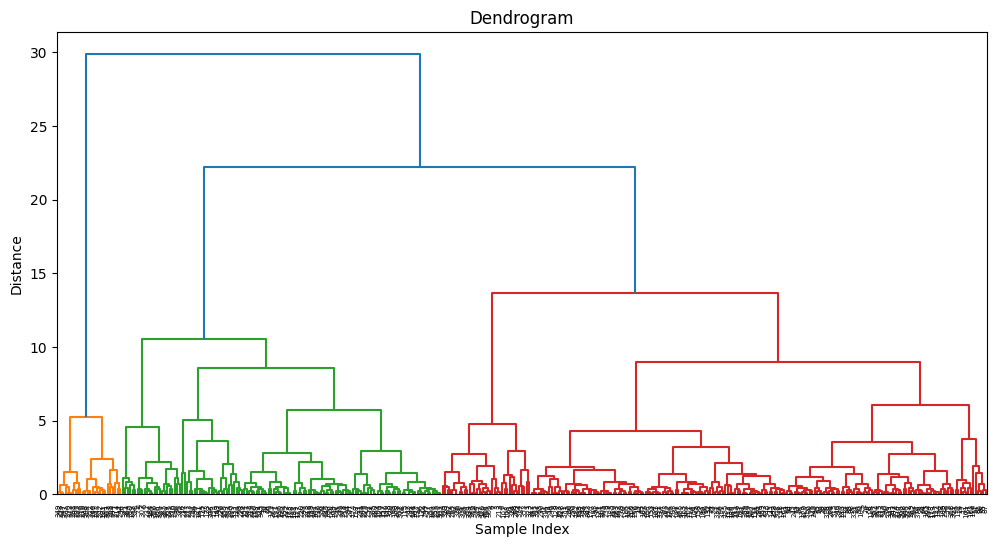

Processed: rotated_image_LC09_L1TP_137044_20220208_20230428_02_T1.jpg, Deforested Area: 45.970000000000006 square meters


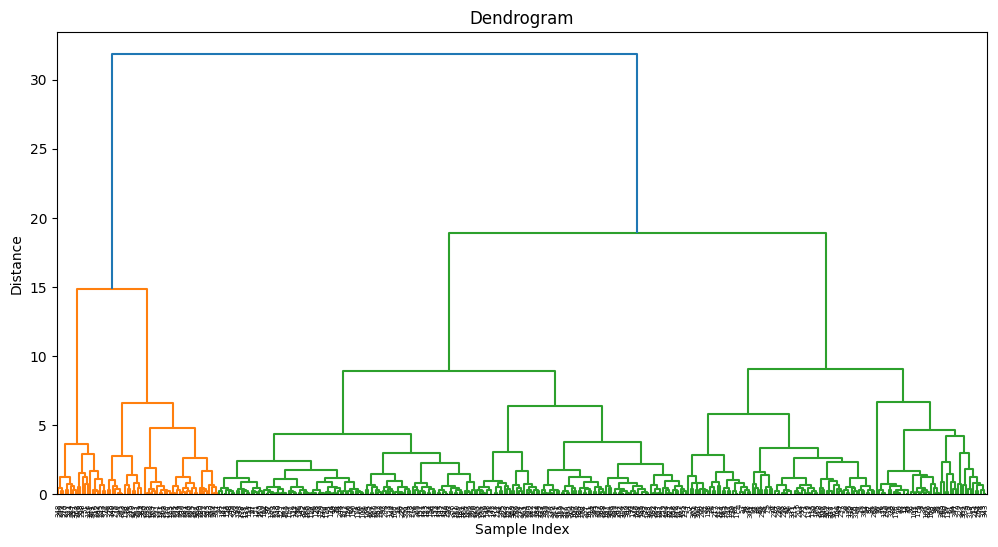

Processed: rotated_image_LC09_L1TP_137044_20221225_20230317_02_T1.jpg, Deforested Area: 44.220000000000006 square meters


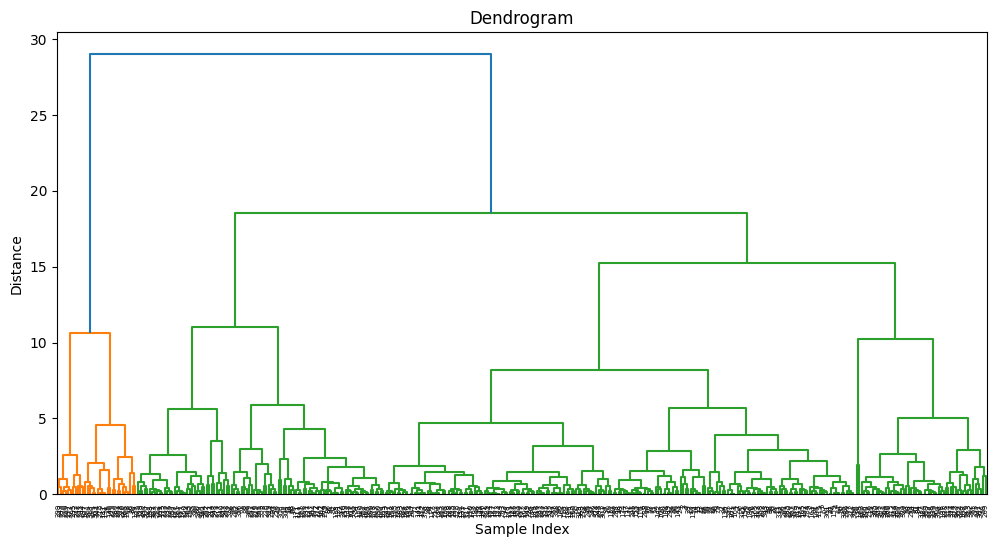

Processed: rotated_image_LC09_L1TP_137044_20231228_20231228_02_T1.jpg, Deforested Area: 15.700000000000001 square meters


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.preprocessing import StandardScaler

def deforestation_segmentation(image_path, scale=1.0, downsample_factor=0.05):
    try:
        # Load the image
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB

        # Downsample the image
        small_image = cv2.resize(image, None, fx=downsample_factor, fy=downsample_factor)

        # Flatten the downsampled image
        pixels = small_image.reshape(-1, 3)

        # Standardize the pixel values
        scaler = StandardScaler()
        pixels_std = scaler.fit_transform(pixels)

        # Perform hierarchical clustering
        Z = linkage(pixels_std, method='ward')

        # Determine the optimal number of clusters using the dendrogram
        plt.figure(figsize=(12, 6))
        dendrogram(Z)
        plt.xlabel('Sample Index')
        plt.ylabel('Distance')
        plt.title('Dendrogram')
        plt.show()

        # Cut the dendrogram to get the labels
        max_d = 10  # Adjust this threshold as needed
        labels = fcluster(Z, max_d, criterion='distance')

        # Reshape labels to match the downsampled image shape
        segmented_image = labels.reshape(small_image.shape[0], small_image.shape[1])

        # Upsample the segmented image
        segmented_image = cv2.resize(segmented_image.astype(np.uint8), (image.shape[1], image.shape[0]))

        # Generate mask for deforested areas
        deforestation_mask = (segmented_image == 1)  # Assuming deforested areas are in the first cluster

        # Calculate the area of the segmented deforested region
        area_pixels = np.sum(deforestation_mask)
        area_meters_squared = area_pixels * scale * scale  # Convert pixels to square meters based on the scale

        # Invert the colors to visualize deforested areas as dark
        inverted_mask = 1 - deforestation_mask

        return image, inverted_mask, area_meters_squared
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None, None, None

def process_dataset_deforestation(dataset_path, scale=1.0):
    try:
        # Create output directory if it doesn't exist
        output_dir = os.path.join(dataset_path, "deforestation_masks_hierarchical")
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)

        # Process each image in the dataset directory
        for filename in os.listdir(dataset_path):
            if filename.endswith(".jpeg") or filename.endswith(".jpg"):
                image_path = os.path.join(dataset_path, filename)
                original_img, hierarchical_mask, area = deforestation_segmentation(image_path, scale)

                if original_img is not None and hierarchical_mask is not None and area is not None:
                    # Save the hierarchical mask with deforested areas as dark
                    mask_filename = os.path.splitext(filename)[0] + "_mask_hierarchical_deforestation.png"
                    mask_path = os.path.join(output_dir, mask_filename)
                    plt.imsave(mask_path, hierarchical_mask, cmap='gray')

                    print(f"Processed: {filename}, Deforested Area: {area} square meters")
    except Exception as e:
        print(f"Error processing dataset: {e}")

# Example usage
dataset_path = r"/content/drive/MyDrive/ML PROJECTS/Deforestation Detection/final dataset"
scale = 0.1  # Assuming each pixel represents 0.1 meter
process_dataset_deforestation(dataset_path, scale)

In [ ]:
import os
import cv2
import numpy as np
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift, estimate_bandwidth
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.preprocessing import StandardScaler

def calculate_iou(mask1, mask2):
    intersection = np.logical_and(mask1, mask2)
    union = np.logical_or(mask1, mask2)
    iou_score = np.sum(intersection) / np.sum(union) *100
    return iou_score

def kmeans_segmentation_deforestation(image_path, scale=1.0):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    pixels = image.reshape(-1, 3)

    num_clusters = 2

    kmeans = KMeans(n_clusters=num_clusters, n_init=10, random_state=42)
    kmeans.fit(pixels)

    cluster_labels = kmeans.labels_

    cluster_intensity = [np.mean(pixels[cluster_labels == i]) for i in range(num_clusters)]
    deforested_cluster_index = np.argmin(cluster_intensity)

    segmented_image = cluster_labels.reshape(image.shape[0], image.shape[1])

    deforestation_mask = segmented_image == deforested_cluster_index

    return deforestation_mask

def mean_shift_segmentation_deforestation(image_path, scale=1.0):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    flat_img_array = img.reshape(-1, 3)

    bandwidth = estimate_bandwidth(flat_img_array, quantile=0.2, n_samples=500)

    ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
    ms.fit(flat_img_array)

    labels = ms.labels_

    segmented_image = labels.reshape(img.shape[0], img.shape[1])

    deforestation_mask = (segmented_image == 0)

    return deforestation_mask

def hierarchical_segmentation_deforestation(image_path, scale=1.0, downsample_factor=0.1):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    small_image = cv2.resize(image, None, fx=downsample_factor, fy=downsample_factor)

    pixels = small_image.reshape(-1, 3)

    scaler = StandardScaler()
    pixels_std = scaler.fit_transform(pixels)

    Z = linkage(pixels_std, method='ward')

    max_d = 10
    labels = fcluster(Z, max_d, criterion='distance')

    segmented_image = labels.reshape(small_image.shape[0], small_image.shape[1])

    deforestation_mask = (segmented_image == 1)

    # Resize the hierarchical mask to match the shape of the K-Means mask
    kmeans_mask = kmeans_segmentation_deforestation(image_path, scale)
    deforestation_mask_resized = cv2.resize(deforestation_mask.astype(np.uint8), (kmeans_mask.shape[1], kmeans_mask.shape[0]), interpolation=cv2.INTER_NEAREST)

    return deforestation_mask_resized

# Define the dataset path
dataset_path = r"/content/drive/MyDrive/ML PROJECTS/Deforestation Detection/final dataset"
scale = 0.1  # Assuming each pixel represents 0.1 meter

# Process each image in the dataset directory
for filename in os.listdir(dataset_path):
    if filename.endswith(".jpeg") or filename.endswith(".jpg"):
        image_path = os.path.join(dataset_path, filename)
        kmeans_mask = kmeans_segmentation_deforestation(image_path, scale)
        meanshift_mask = mean_shift_segmentation_deforestation(image_path, scale)
        hierarchical_mask = hierarchical_segmentation_deforestation(image_path, scale)

        # Calculate IoU between each pair of clustering results
        iou_kmeans_meanshift = calculate_iou(kmeans_mask, meanshift_mask)
        iou_kmeans_hierarchical = calculate_iou(kmeans_mask, hierarchical_mask)
        iou_meanshift_hierarchical = calculate_iou(meanshift_mask, hierarchical_mask)

        print(f"IoU for {filename}:")
        print(f"K-Means vs. Mean Shift: {iou_kmeans_meanshift}")
        print(f"K-Means vs. Hierarchical: {iou_kmeans_hierarchical}")
        print(f"Mean Shift vs. Hierarchical: {iou_meanshift_hierarchical}")


IoU for rotated_image_LC08_L1TP_137044_20131224_20200912_02_T1.jpg:
K-Means vs. Mean Shift: 1.1839665892526086
K-Means vs. Hierarchical: 9.280952511590902
Mean Shift vs. Hierarchical: 4.335040635956763
IoU for rotated_image_LC08_L1TP_137044_20141125_20200910_02_T1.jpg:
K-Means vs. Mean Shift: 2.762
K-Means vs. Hierarchical: 24.153851263825686
Mean Shift vs. Hierarchical: 1.6322546737743076
IoU for rotated_image_LC08_L1TP_137044_20151112_20200908_02_T1.jpg:
K-Means vs. Mean Shift: 2.741397706054948
K-Means vs. Hierarchical: 9.201344016541741
Mean Shift vs. Hierarchical: 0.5013687674940789
IoU for rotated_image_LC08_L1TP_137044_20160115_20200907_02_T1.jpg:
K-Means vs. Mean Shift: 5.575333333333334
K-Means vs. Hierarchical: 3.0050611556305356
Mean Shift vs. Hierarchical: 12.34810186202782
IoU for rotated_image_LC08_L1TP_137044_20161216_20200905_02_T1.jpg:
K-Means vs. Mean Shift: 2.310464495461826
K-Means vs. Hierarchical: 9.914340618180633
Mean Shift vs. Hierarchical: 1.082051645521771
Io

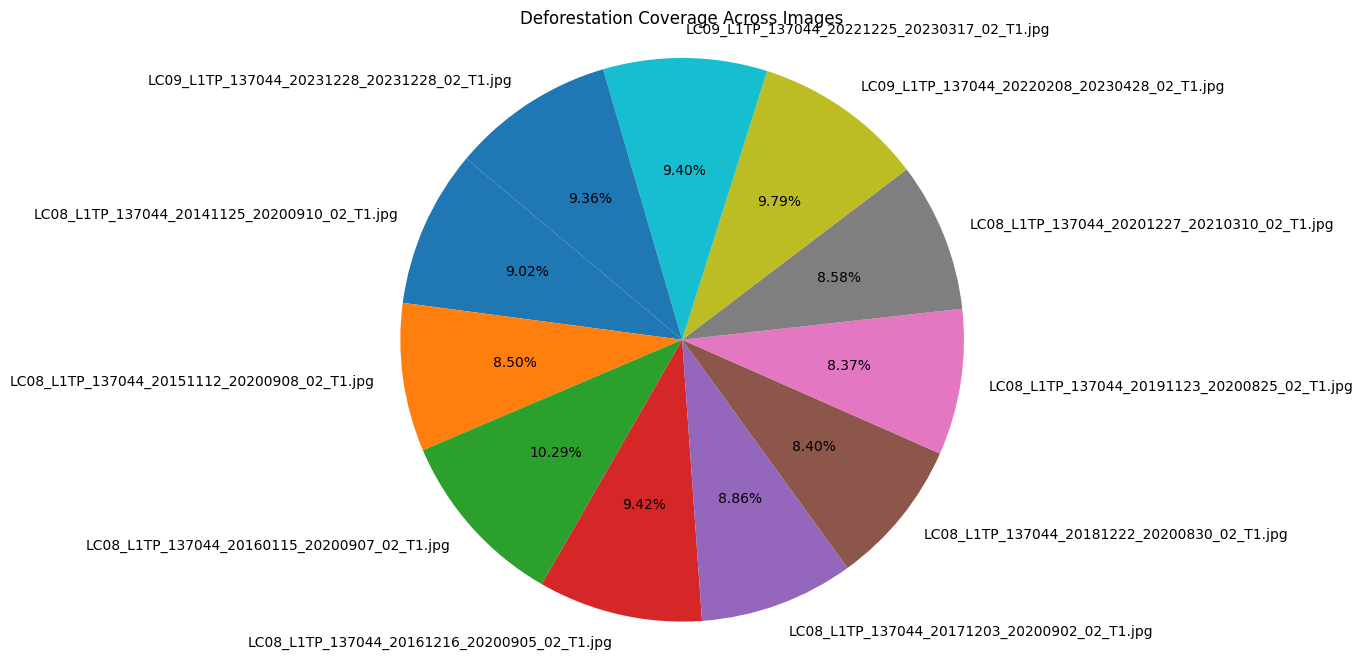

In [ ]:
import matplotlib.pyplot as plt

# Deforestation coverage data
deforestation_coverage = {
    "LC08_L1TP_137044_20141125_20200910_02_T1.jpg": 18.72,
    "LC08_L1TP_137044_20151112_20200908_02_T1.jpg": 17.65,
    "LC08_L1TP_137044_20160115_20200907_02_T1.jpg": 21.36,
    "LC08_L1TP_137044_20161216_20200905_02_T1.jpg": 19.56,
    "LC08_L1TP_137044_20171203_20200902_02_T1.jpg": 18.39,
    "LC08_L1TP_137044_20181222_20200830_02_T1.jpg": 17.44,
    "LC08_L1TP_137044_20191123_20200825_02_T1.jpg": 17.38,
    "LC08_L1TP_137044_20201227_20210310_02_T1.jpg": 17.80,
    "LC09_L1TP_137044_20220208_20230428_02_T1.jpg": 20.32,
    "LC09_L1TP_137044_20221225_20230317_02_T1.jpg": 19.52,
    "LC09_L1TP_137044_20231228_20231228_02_T1.jpg": 19.43
}

# Extracting image names and corresponding deforestation coverage values
image_names = list(deforestation_coverage.keys())
coverage_values = list(deforestation_coverage.values())

# Plotting the pie chart
plt.figure(figsize=(8, 8))
plt.pie(coverage_values, labels=image_names, autopct='%1.2f%%', startangle=140)
plt.title('Deforestation Coverage Across Images')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.show()
